<a href="https://colab.research.google.com/github/maitysuvo19/News-Articles-Classification/blob/main/Real_news_classification_with__Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#basic imports
import os
import pandas as pd
import numpy as np

Preparing the data

In [ ]:
!unzip news.zip -d news

Archive:  news.zip
   creating: news/news article/News Articles/
   creating: news/news article/News Articles/business/
  inflating: news/news article/News Articles/business/001.txt  
  inflating: news/news article/News Articles/business/002.txt  
  inflating: news/news article/News Articles/business/003.txt  
  inflating: news/news article/News Articles/business/004.txt  
  inflating: news/news article/News Articles/business/005.txt  
  inflating: news/news article/News Articles/business/006.txt  
  inflating: news/news article/News Articles/business/007.txt  
  inflating: news/news article/News Articles/business/008.txt  
  inflating: news/news article/News Articles/business/009.txt  
  inflating: news/news article/News Articles/business/010.txt  
  inflating: news/news article/News Articles/business/011.txt  
  inflating: news/news article/News Articles/business/012.txt  
  inflating: news/news article/News Articles/business/013.txt  
  inflating: news/news article/News Articles/bus

In [ ]:
# Step 1 - Get the file details
directory = []
file = []
title = []
text = []
label = []
datapath = '/content/news/news article' 
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        #print(filename)
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

#    

In [ ]:
fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)), 
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)

print("FullDf : ", fulldf.shape)
print("DF : ", df.shape)

FullDf :  (2225, 5)
DF :  (2225, 2)


In [ ]:
df.head(5)

,text,label
0,Scotland's first minister has told a group o...,politics
1,Charles Kennedy is far too canny to make any...,politics
2,"Tony Blair has told Labour supporters he's ""...",politics
3,Two of Britain's big trade unions could merg...,politics
4,UK Foreign Secretary Jack Straw has defended...,politics


Bert

In [ ]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

     |████████████████████████████████| 133kB 16.2MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
     |████████████████████████████████| 7.4MB 22.4MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
  Created wheel for boto3: filename=boto3-1.17.56-py2.py3-none-any.whl size=128920 sha256=54b856d9a0462995cd9f61d156e907675e1ce36a145fec3a483e247dbb40fb66
  Stored in directory: /root/.cache/pip/wheels/77/41/89/dd0e45e43a0a79971ee76752d9059b4c10b1edcd7b1fb14006
Successfully built boto3
ERROR: botocore 1.20.56 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [ ]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

In [ ]:
df['label'].value_counts()

3    511
0    510
2    417
4    401
1    386
Name: label, dtype: int64

In [ ]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['text']=df['text'].apply(strip)

In [ ]:
df.head()

,text,label
0,Scotland's first minister has told a group o...,2
1,Charles Kennedy is far too canny to make any...,2
2,Tony Blair has told Labour supporters he's b...,2
3,Two of Britain's big trade unions could merg...,2
4,UK Foreign Secretary Jack Straw has defended...,2


In [ ]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = df['text']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [ ]:
sentence[0]

"[CLS]   Scotland's first minister has told a group of high school pupils that it is okay to get drunk once in a while  Jack McConnell was speaking to more than 100 secondary pupils from schools in the Highlands about the problems of binge drinking and drink promotions He has been criticised by the SNP for encouraging young people to get drunk But the Scottish Executive has insisted Mr McConnell was speaking about adults and his comments were a recognition that people will get drunk The first minister's comments came in a question and answer session at Glenurquhart High School in Inverness, attended by pupils from a number of secondary schools A Highland councillor who was at the event has also defended Mr McConnell Margaret Davidson, the independent member for the Loch Ness West, said the first minister was speaking in a very general way and she was sure he was speaking about adults at the time  When one pupil asked Mr McConnell how the executive proposed to tackle underage drinking, 

We now need to tokenize our text into tokens that correspond to BERT’s vocabulary.

In [ ]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 673909.71B/s]


Tokenize the first sentence:
['[CLS]', 'scotland', "'", 's', 'first', 'minister', 'has', 'told', 'a', 'group', 'of', 'high', 'school', 'pupils', 'that', 'it', 'is', 'okay', 'to', 'get', 'drunk', 'once', 'in', 'a', 'while', 'jack', 'mcconnell', 'was', 'speaking', 'to', 'more', 'than', '100', 'secondary', 'pupils', 'from', 'schools', 'in', 'the', 'highlands', 'about', 'the', 'problems', 'of', 'bing', '##e', 'drinking', 'and', 'drink', 'promotions', 'he', 'has', 'been', 'criticised', 'by', 'the', 's', '##np', 'for', 'encouraging', 'young', 'people', 'to', 'get', 'drunk', 'but', 'the', 'scottish', 'executive', 'has', 'insisted', 'mr', 'mcconnell', 'was', 'speaking', 'about', 'adults', 'and', 'his', 'comments', 'were', 'a', 'recognition', 'that', 'people', 'will', 'get', 'drunk', 'the', 'first', 'minister', "'", 's', 'comments', 'came', 'in', 'a', 'question', 'and', 'answer', 'session', 'at', 'glen', '##ur', '##qu', '##hart', 'high', 'school', 'in', 'inverness', ',', 'attended', 'by', 'pupi

In [ ]:
labels = list(df['label'])#storing the labels

We now need to give BERT input ids,ie, a sequence of integers which uniquely identify each input token to its index number.

In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

BERT is a MLM(Masked Language Model). We have to define its mask.

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Now we need to split the data into train and validation. Convert it to tensors and then create iterator for our data

In [ ]:
# Select a batch size for training. 
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)#binary classification
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4282651076403757


Epoch:  25%|██▌       | 1/4 [00:38<01:55, 38.40s/it]

Validation Accuracy: 0.9776785714285714
Train loss: 0.11378734011853499


Epoch:  50%|█████     | 2/4 [01:16<01:16, 38.38s/it]

Validation Accuracy: 0.9821428571428571
Train loss: 0.06280491074975876


Epoch:  75%|███████▌  | 3/4 [01:54<00:38, 38.28s/it]

Validation Accuracy: 0.9821428571428571
Train loss: 0.024466724118350873


Epoch: 100%|██████████| 4/4 [02:32<00:00, 38.22s/it]

Validation Accuracy: 0.9776785714285714


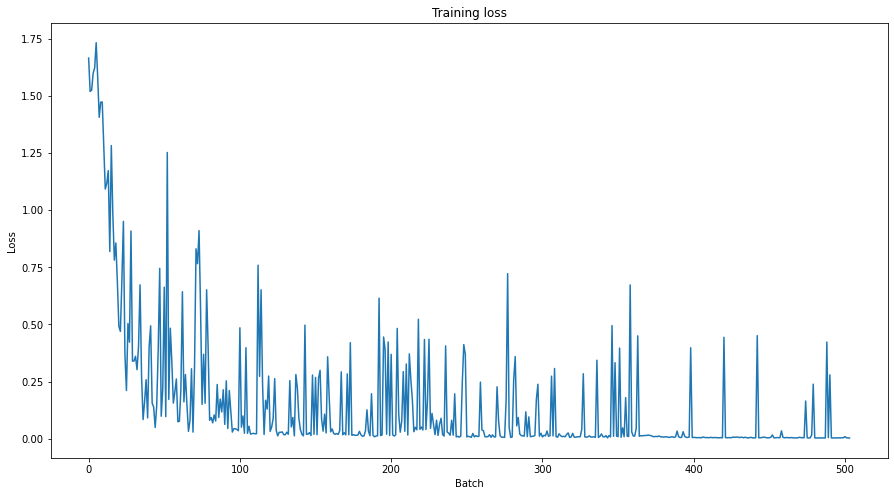

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4
# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()